<a href="https://colab.research.google.com/github/ztokar/Pytorch-tutorial/blob/main/CausalImpact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install tfcausalimpact

In [2]:
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
#dates
treatment_start="2020-10-20"
treatment_end="2020-10-23"
training_start="2020-09-01"
training_end="2020-10-19"
end_stock="2020-10-24"

In [4]:
#ticker info
y=["BTC-USD"]
y=yf.download(tickers=y, start=training_start,end=end_stock,interval='1d')
y=y['Adj Close'].rename('y')
y[:5]

[*********************100%***********************]  1 of 1 completed


Date
2020-09-01    11970.478516
2020-09-02    11414.034180
2020-09-03    10245.296875
2020-09-04    10511.813477
2020-09-05    10169.567383
Name: y, dtype: float64

In [5]:
stocks=['ZAL.DE','SQ','CRSP','TRMB','JD','DE','KTOS','GOOG']
X=yf.download(tickers=stocks, start=training_start,end=end_stock,interval='1d')
X=X.iloc[:,:len(stocks)]
X.head(1)

[*********************100%***********************]  8 of 8 completed


Adj Close                                                         \
                 CRSP          DE     GOOG         JD       KTOS          SQ   
Date                                                                           
2020-09-01  93.419998  210.029633  83.0355  79.267685  19.700001  166.660004   

                          
             TRMB ZAL.DE  
Date                      
2020-09-01  53.41   77.0

In [6]:
X.columns=X.columns.droplevel()
X.head()

,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,
2020-09-01,93.419998,210.029633,83.035500,79.267685,19.700001,166.660004,53.410000,77.000000
2020-09-02,93.930000,209.470078,86.414001,79.959557,19.910000,162.880005,54.310001,77.000000
2020-09-03,85.690002,203.391754,82.092003,75.952454,19.520000,152.860001,50.900002,75.080002
2020-09-04,82.019997,203.903122,79.552002,76.874954,19.260000,146.389999,49.959999,71.739998
2020-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


In [7]:
X.index=X.index.tz_localize(None)

In [8]:
df=pd.concat([y,X],axis=1).dropna()
df.head()

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,210.029633,83.035500,79.267685,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,93.930000,209.470078,86.414001,79.959557,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,85.690002,203.391754,82.092003,75.952454,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,82.019997,203.903122,79.552002,76.874954,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,81.459999,202.841827,76.619499,73.242615,19.230000,139.110001,49.139999,73.440002


In [9]:
df_training=df[df.index <= training_end]
df_training.tail(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-10-19,11742.037109,107.720001,230.57872,76.730499,77.461121,20.639999,186.960007,51.970001,85.0


In [11]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(x=df_training.y)[1]

0.0987470320882271

In [13]:
differencing= df_training.pct_change().dropna()
differencing.head(2)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000
2020-09-03,-0.102395,-0.087725,-0.029018,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935


<Axes: >

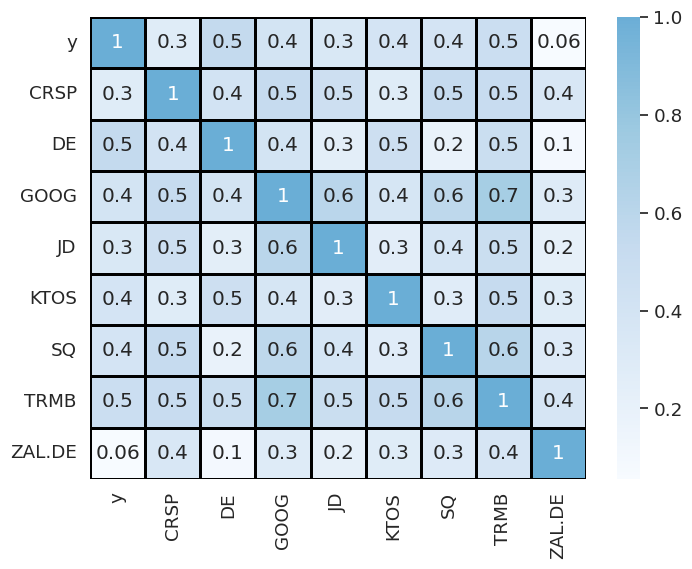

In [20]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(differencing.corr(),annot=True, linewidths=1, cmap='Blues',fmt='.1g',center=True, linecolor='black' )

In [21]:
df_final=df.drop(columns=['ZAL.DE'])

In [22]:
pre_period=[training_start,training_end]
post_period=[treatment_start,treatment_end]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


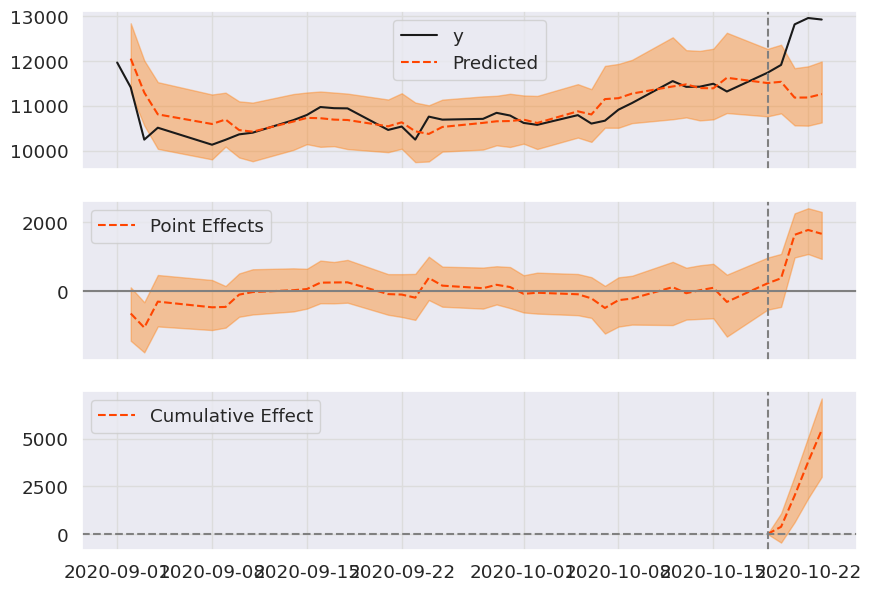

In [23]:
impact=CausalImpact(data=df_final,pre_period=pre_period, post_period=post_period)
impact.plot()

In [24]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11294.15 (270.92)  45176.61 (1083.69)
95% CI                    [10876.26, 11938.25][43505.02, 47753.0]

Absolute effect (s.d.)    1365.21 (270.92)   5460.85 (1083.69)
95% CI                    [721.11, 1783.11]  [2884.45, 7132.43]

Relative effect (s.d.)    12.09% (2.4%)      12.09% (2.4%)
95% CI                    [6.38%, 15.79%]    [6.38%, 15.79%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
